In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import pandas as pd
import category_encoders as ce
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import time



#TODO: Train Randon forest classifiers

#read the data
data_path = 'data/train.csv'
TrainDF = pd.read_csv(data_path)
print(TrainDF.head())

print(TrainDF.columns)
#potenfial config columns
#ignoring cabin
feature_columns = ['age', 'embarked', 'fare', 'name', 'parch', 'pclass',
       'sex', 'sibsp']
target_column = ['survived']

#split train_test
X_train, X_test, y_train, y_test = train_test_split(TrainDF[feature_columns], TrainDF[target_column].values.ravel())


print(len(X_train))

print(len(X_test))

print(len(y_train))

print(len(y_test))


#X_train = TrainDF[feature_columns]

#convert to np array
#y_train = TrainDF[target_column].values.ravel()

#labelendoding
categorical_columns = ['embarked', 'name', 'parch', 'pclass',
       'sex']
# Labels are the values we want to predict
OEncoder = ce.ordinal.OrdinalEncoder(cols=categorical_columns)
X_train = OEncoder.fit_transform(X_train)
X_train = X_train.fillna(X_train.mean())

X_test = OEncoder.transform(X_test)
X_test = X_test.fillna(X_train.mean())


#define classifier
clf = RandomForestClassifier()
clf.fit(X = X_train,y = y_train)



print(X_train.columns)
importances = clf.feature_importances_
print(importances)

y_pred = clf.predict(X_test)

print(len(y_pred))

print(len(y_test))
#accuracy
print(metrics.accuracy_score(y_test,y_pred))

print(metrics.roc_auc_score(y_test,y_pred))
#TODO: perform cross validation

print(cross_val_score(clf, X_train, y_train, cv=7))

#TODO: Explain what all the hyperparameters do


#TODO: Use hyperparamenter tuning
from hyperopt import hp
from hyperopt import STATUS_OK

initial_params = clf.get_params()
print(initial_params)

clf.set_params(**initial_params)

#print(type(str(initial_params)))
print(cross_val_score(clf, X_train, y_train, cv=7))


def the_objective(params_d, X_train_s = X_train,y_train_s = y_train,X_test = X_test, y_test = y_test):
       '''
       :param params: Random Forest Params
       :param cv: Cross Validation folds
       :return:
       '''

       clf_ =  RandomForestClassifier(params_d)
       #clf_.set_params(**params)
       print("Trying the set of paras {}".format(params_d))
       clf_.fit(X_train_s,y_train_s)
       y_pred = clf_.predict(X_test)
       print("The params of the clf are {}".format(clf.get_params()))
       accuracy_score =  metrics.accuracy_score(y_test, y_pred)
       print("The accuracy score is {}".format(accuracy_score))

       accuracy_inverse = 1 - accuracy_score
       #best = cv_results.mean()
       #print(cv_results)
       return {'loss': accuracy_inverse, 'params': params, 'status': STATUS_OK, 'accuracy': accuracy_score}

#define space
'''
Using this set of hyperparams
n_estimators = number of trees in the foreset
max_features = max number of features considered for splitting a node
max_depth = max number of levels in each decision tree
min_samples_split = min number of data points placed in a node before the node is split
min_samples_leaf = min number of data points allowed in a leaf node
bootstrap = method for sampling data points (with or without replacement)
Taking the Bayesian Strategy to find the best combination
'''

import numpy as np

grid_space = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


bayes_space = {'bootstrap': hp.choice('bootstrap',[True, False]),
 'max_depth': hp.choice('max_depth', np.arange(3,30, dtype= int)),
 'min_samples_leaf': hp.choice('min_samples_leaf', np.arange(3,60, dtype= int)),
 'min_samples_split': hp.choice('min_samples_split', np.arange(3,100, dtype= int)),
 'n_estimators': hp.choice('n_estimators', np.arange(200,2000, dtype= int))
               }


#testing space
from hyperopt.pyll.stochastic import sample
print('Testing Space')
print(sample(bayes_space))

#run tunning

from hyperopt import Trials, tpe, fmin


bayes_trials = Trials()

best = fmin(fn = the_objective, space = bayes_space, algo = tpe.suggest, max_evals = 10, trials= bayes_trials)

print(best)

#print
#unnesting the parameters to columns
#Getting all results
df_best = pd.DataFrame(bayes_trials.results)

#unnesting the params dictionary
df_best = pd.concat([df_best, df_best.params.apply(pd.Series)], axis = 1, sort = False)
#dropping the dictionary column
df_best = df_best.drop(['params'], axis = 1)
print(df_best.head())

df_best['iteration'] = df_best.index + 1

print(df_best.columns)

import matplotlib.pyplot as plt
import seaborn as sns

print_list = ['accuracy', 'loss', 'max_depth',
       'min_samples_leaf', 'min_samples_split', 'n_estimators', 'iteration']

fig, ax = plt.subplots()

for i,item in enumerate(print_list):
       sns.regplot('iteration', item, data = df_best)
       plt.show()

#train model with best hyperparameters

     id   age cabin embarked     fare                          name  parch  \
0   306  54.0   D26        S  77.2875   White, Mr. Percival Wayland      1   
1   927   NaN   NaN        C  14.4542            Khalil, Mr. Betros      0   
2   642  13.0   NaN        S  31.3875  Asplund, Master. Filip Oscar      2   
3  1294  28.5   NaN        S  16.1000          Williams, Mr. Leslie      0   
4  1015  55.5   NaN        S   8.0500              Meo, Mr. Alfonzo      0   

   pclass   sex  sibsp  survived      ticket  
0       1  male      0         0       35281  
1       3  male      1         0        2660  
2       3  male      4         0      347077  
3       3  male      0         0       54636  
4       3  male      0         0  A.5. 11206  
Index(['id', 'age', 'cabin', 'embarked', 'fare', 'name', 'parch', 'pclass',
       'sex', 'sibsp', 'survived', 'ticket'],
      dtype='object')
687
229
687
229
Index(['age', 'embarked', 'fare', 'name', 'parch', 'pclass', 'sex', 'sibsp'], dtype='obje

ValueError: n_estimators must be an integer, got <class 'dict'>.

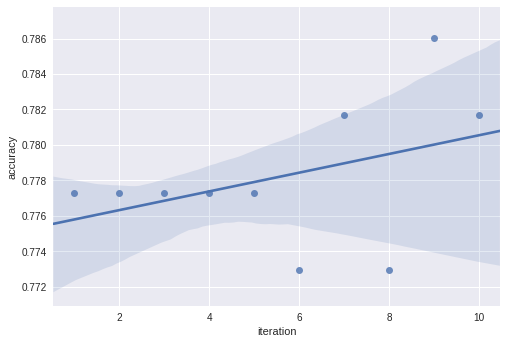

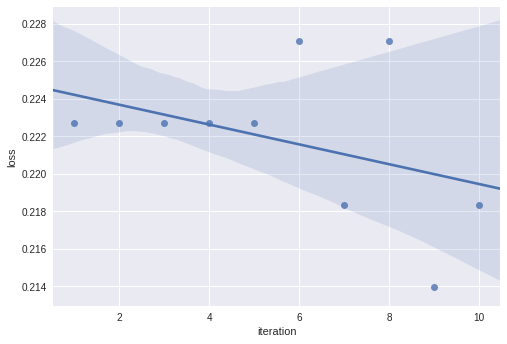

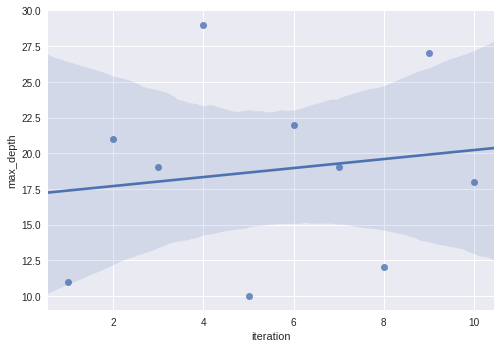

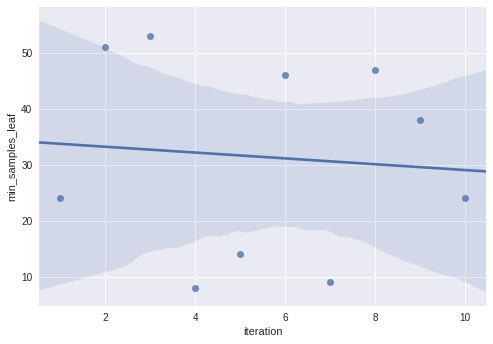

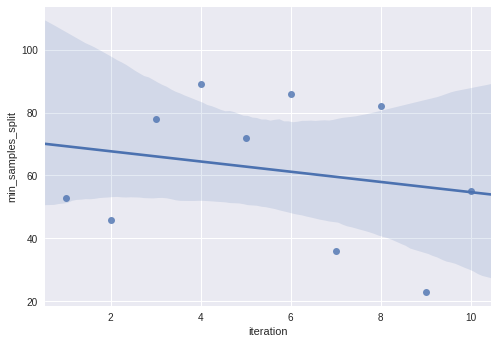

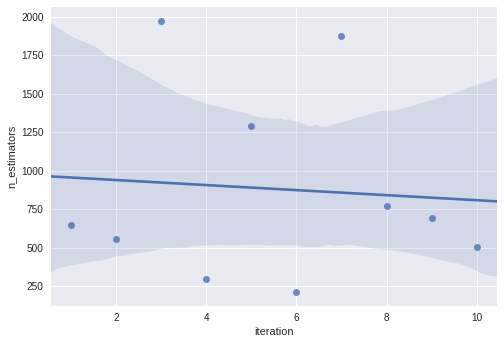

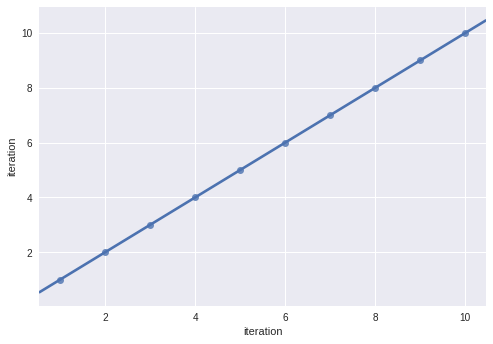

In [5]:
fig, ax = plt.subplots()

for i,item in enumerate(print_list):
       sns.regplot('iteration', item, data = df_best)
       plt.show()

## Titanic XGBoost

In [244]:
import xgboost as xgb
from xgboost import XGBClassifier
#define objective
#train model 

In [245]:
#Preparing the data
data_path = 'data/train.csv'
TrainDF = pd.read_csv(data_path)
X_train, X_test, y_train, y_test = train_test_split(TrainDF[feature_columns],
                                                    TrainDF[target_column].values.ravel(), test_size = 0.25, random_state = 42)

In [246]:
#some feature engineering
categorical_columns = ['embarked', 'name', 'parch', 'pclass',
       'sex']
# Labels are the values we want to predict
OEncoder = ce.ordinal.OrdinalEncoder(cols=categorical_columns)
X_train = OEncoder.fit_transform(X_train)
X_train = X_train.fillna(X_train.mean())

#applying the same encoder as the training set
X_test = OEncoder.transform(X_test)

#filling witht the mean of the training set
X_test = X_test.fillna(X_train.mean())

In [247]:
#Checking types
type(X_train)

pandas.core.frame.DataFrame

#### Hyperparameters for XGB


In [248]:
#defining parameter space
bayes_space_xgb = {'max_depth': hp.choice('max_depth', np.arange(3,30, dtype= int)),
                   'n_estimators': hp.choice('n_estimators', np.arange(200,2000, dtype= int)),
                   'objective': 'binary:hinge',
                   'colsample_bytree' : hp.uniform('colsample_bytree',0.6,1)
                   
               }

In [249]:
#testing space
from hyperopt.pyll.stochastic import sample
print('Testing Space')
print(sample(bayes_space_xgb))

Testing Space
{'colsample_bytree': 0.7356167443482333, 'max_depth': 12, 'n_estimators': 769, 'objective': 'binary:hinge'}


In [250]:
#trying to solve issue with setting parameters
sample_params = sample(bayes_space_xgb)
print(sample_params)
print(type(sample_params))

{'colsample_bytree': 0.9740461947781444, 'max_depth': 4, 'n_estimators': 390, 'objective': 'binary:hinge'}
<class 'dict'>


In [251]:
##Need to pass params as a s keyword argument dictionary
xgb_clf = XGBClassifier(**sample_params) 

In [252]:
xgb_clf.fit(X_train.as_matrix(),y_train)

/home/raul/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9740461947781444, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=4, min_child_weight=1, missing=None,
       n_estimators=390, n_jobs=1, nthread=None, objective='binary:hinge',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [253]:
xgb_clf.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9740461947781444, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=4, min_child_weight=1, missing=None,
       n_estimators=390, n_jobs=1, nthread=None, objective='binary:hinge',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)>

In [254]:
best = xgb.cv(params = sample_params, dtrain = xgb.DMatrix(X_train, label = y_train), metrics = ['error'], nfold = 5)
print(best)
print(best['test-error-mean'].mean())

[13:53:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[13:53:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[13:53:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[13:53:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[13:53:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[13:53:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[13:53:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[13:53:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[13:53:51] /work

In [255]:
def objective_xgb(params_space, X_train = X_train, y_train = y_train ):
    '''
    arts params: hyperparameters we wan to ptimize
    n_folds: Number of k cross validation groups
    '''    
    sample_params = sample(params_space)
    
    xgb_results = xgb.cv(params = sample_params, dtrain = xgb.DMatrix(X_train, label = y_train), metrics = ['error'], nfold = 5,
                        verbose_eval = False) 
    loss = xgb_results['test-error-mean'].mean()
    print("Parameters in trial")
    print(sample_params)
    print("The error for this iteration is {}".format(loss))
    #TODO implement her the measure of time      
    return {'loss': loss, 'params': sample_params, 'status': STATUS_OK}

In [256]:
#TODO: What is status doing?
#TODO: What are the neccesary parametters for hyperopt optimitation 

### Hyperopt  tuning 

In [265]:
#run tunning
from hyperopt import Trials, tpe, fmin, STATUS_OK
bayes_trials_xgb = Trials()
best_params_xgb = fmin(fn = objective_xgb, space = bayes_space_xgb, algo = tpe.suggest, max_evals = 50,
            trials= bayes_trials_xgb)
print(best)

[13:55:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 0 pruned nodes, max_depth=20
[13:55:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned nodes, max_depth=16
[13:55:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned nodes, max_depth=17
[13:55:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 330 extra nodes, 0 pruned nodes, max_depth=19
[13:55:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 0 pruned nodes, max_depth=16
[13:55:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=15
[13:55:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=16
[13:55:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned nodes, max_depth=17


[13:55:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=16
[13:55:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=15
[13:55:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=13
[13:55:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=15
[13:55:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=14
[13:55:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=15
[13:55:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=17
[13:55:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned nodes, max_depth=17


[13:55:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=14
[13:55:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=14
[13:55:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=13
[13:55:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=14
[13:55:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=14
[13:55:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=14
[13:55:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=14
[13:55:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=14


[13:55:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=16
[13:55:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=15
[13:55:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=13
[13:55:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=15
[13:55:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=14
[13:55:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=15
[13:55:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=17
[13:55:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned nodes, max_depth=17


[13:55:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=8
[13:55:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=8
[13:55:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=8
[13:55:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=8
[13:55:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=8
[13:55:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=8
[13:55:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=8
[13:55:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=8
[13:55:06] 

[13:55:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=16
[13:55:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=15
[13:55:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=13
[13:55:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=15
[13:55:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=14
[13:55:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=15
[13:55:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=17
[13:55:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned nodes, max_depth=17


[13:55:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=10
[13:55:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=10
[13:55:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=10
[13:55:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=10
[13:55:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=10
[13:55:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=10
[13:55:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=10
[13:55:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=10


[13:55:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=15
[13:55:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=15
[13:55:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=13
[13:55:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=15
[13:55:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=14
[13:55:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=15
[13:55:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=15
[13:55:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=15


[13:55:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 0 pruned nodes, max_depth=21
[13:55:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 0 pruned nodes, max_depth=21
[13:55:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 0 pruned nodes, max_depth=17
[13:55:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 0 pruned nodes, max_depth=20
[13:55:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 0 pruned nodes, max_depth=16
[13:55:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=15
[13:55:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=16
[13:55:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=17


[13:55:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=19
[13:55:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=17
[13:55:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=17
[13:55:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=19
[13:55:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pruned nodes, max_depth=19
[13:55:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=15
[13:55:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=15
[13:55:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=17


[13:55:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:55:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:55:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:55:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:55:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:55:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:55:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:55:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:55:10] /work

[13:55:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:55:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:55:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:55:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:55:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:55:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:55:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:55:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:55:11] /work

[13:55:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:55:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:55:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:55:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:55:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:55:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:55:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:55:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:55:11] /work

[13:55:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 0 pruned nodes, max_depth=21
[13:55:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=17
[13:55:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=17
[13:55:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 0 pruned nodes, max_depth=20
[13:55:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=22
[13:55:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=15
[13:55:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=15
[13:55:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=17


[13:55:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 0 pruned nodes, max_depth=21
[13:55:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=17
[13:55:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=17
[13:55:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 0 pruned nodes, max_depth=20
[13:55:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=22
[13:55:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=15
[13:55:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=15
[13:55:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=17


[13:55:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 0 pruned nodes, max_depth=21
[13:55:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=17
[13:55:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=17
[13:55:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 0 pruned nodes, max_depth=20
[13:55:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=21
[13:55:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=15
[13:55:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=15
[13:55:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=17


[13:55:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[13:55:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[13:55:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[13:55:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[13:55:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[13:55:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[13:55:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[13:55:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[13:55:14] /work

[13:55:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=16
[13:55:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=16
[13:55:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 0 pruned nodes, max_depth=16
[13:55:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=16
[13:55:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 0 pruned nodes, max_depth=16
[13:55:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=15
[13:55:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=16
[13:55:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=16


[13:55:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[13:55:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[13:55:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[13:55:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[13:55:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[13:55:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[13:55:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[13:55:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[13:55:15] /work

[13:55:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[13:55:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=9
[13:55:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=9
[13:55:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[13:55:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=9
[13:55:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[13:55:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=9
[13:55:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=9
[13:55:16

[13:55:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[13:55:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[13:55:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[13:55:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[13:55:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[13:55:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[13:55:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[13:55:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[13:55:16] /work

[13:55:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=16
[13:55:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=15
[13:55:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=13
[13:55:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=15
[13:55:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=14
[13:55:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=15
[13:55:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=17
[13:55:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned nodes, max_depth=17


[13:55:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=16
[13:55:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=15
[13:55:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=13
[13:55:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=15
[13:55:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=14
[13:55:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=15
[13:55:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=17
[13:55:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned nodes, max_depth=17


[13:55:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 0 pruned nodes, max_depth=21
[13:55:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=17
[13:55:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=17
[13:55:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 0 pruned nodes, max_depth=20
[13:55:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=22
[13:55:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=15
[13:55:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=15
[13:55:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=17


[13:55:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[13:55:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[13:55:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[13:55:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[13:55:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[13:55:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[13:55:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[13:55:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[13:55:19] /work

In [266]:
best_params_xgb['objective']=  'binary:hinge'
print(best_params_xgb)

{'colsample_bytree': 0.7604004926029934, 'max_depth': 1, 'n_estimators': 1097, 'objective': 'binary:hinge'}


In [267]:
#Fit with used parameters
#Predict on Test set and get accuracy

In [268]:
bst_xgb = xgb.train(best_params_xgb, 
                    dtrain = xgb.DMatrix(X_train, label = y_train))

[13:55:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[13:55:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[13:55:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[13:55:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[13:55:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[13:55:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[13:55:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[13:55:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[13:55:20] /workspace/sr

In [269]:
print(best_params_xgb)

{'colsample_bytree': 0.7604004926029934, 'max_depth': 1, 'n_estimators': 1097, 'objective': 'binary:hinge'}


In [270]:
dtest = xgb.DMatrix(X_test)
y_pred_xgb = bst_xgb.predict(dtest)

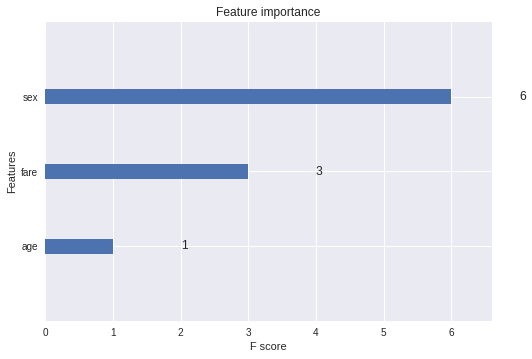

In [271]:
xgb.plot_importance(bst_xgb)
plt.show()

In [272]:
metrics.accuracy_score(y_test,y_pred_xgb)

0.7729257641921398